In [1]:
# Change directory to the parent directory
import os
os.path.abspath(os.curdir)
os.chdir("..")
os.getcwd()

import numpy as np
import pandas as pd

from source import *

from scipy.optimize import minimize

import warnings
warnings.filterwarnings("ignore")

# Data Processing

In [2]:
# Climate Policy Uncertainty Index
# source: https://www.policyuncertainty.com/climate_uncertainty.html
cpu = pd.read_csv('./data/cpu.csv', sep=',')

# EM-DAT International disaster database
# Source: https://www.emdat.be/
emdat = pd.read_csv('./data/EMDAT.csv', encoding_errors='ignore')

# Natural Gas Futures price
# Source: https://www.eia.gov/dnav/ng/hist/rngc1d.htm
natgas_futures = pd.read_csv('./data/natgas_futures_price.csv', sep=',')

In [3]:
# Combine Dataframe

# Prepare CPU index data
cpu[['date', 'cpu_index', 'old_cpu_index']] = cpu['date,cpu_index,old_cpu_index'].str.split(',', expand=True)
cpu['date']= pd.to_datetime(cpu['date'],format='%b-%y')
cpu.set_index('date', inplace=True)
cpu.drop(columns=['date,cpu_index,old_cpu_index','old_cpu_index'], inplace=True)
cpu['cpu_index'] = pd.to_numeric(cpu['cpu_index'])

# Process EM-DAT data
emdat = emdat[['Country', 'Subregion', 'Region', 
               'Disaster Group', 'Disaster Subgroup', 
               'Disaster Type','Start Year', 'Start Month', 
               'End Year', 'End Month']]
emdat.dropna(inplace=True)

# Key date should be based on the start date of the disaster, when market may react
emdat['Date'] =\
    pd\
    .to_datetime(
        emdat['Start Year'].astype(str) 
        + '-' 
        + emdat['Start Month'].astype(int).astype(str).str.zfill(2))

# Create a df with monthly frequencies as series
emdat_mthly_freq =\
(
    emdat
        .groupby(by = 'Date')
        .count()
        [['Disaster Group']]
        .rename(columns = {'Disaster Group' : 'Monthly_Disaster_Freq'})
)

# Futures prices
natgas_futures['Date']= pd.to_datetime(natgas_futures['Date'],format='%Y-%m-%d')
natgas_futures.set_index('Date', inplace=True)
# Log returns rescaled to 100
natgas_futures['daily_return'] =\
np.log(
    natgas_futures['natgas_future_price']/
    natgas_futures['natgas_future_price'].shift()
) * 100

# Consolidating the three data series into single dataframe 
natgas_futures['YYYY-MM'] = natgas_futures.index.to_period('M')
cpu['YYYY-MM'] = cpu.index.to_period('M')
emdat_mthly_freq['YYYY-MM'] = emdat_mthly_freq.index.to_period('M')

data =\
    natgas_futures\
        .merge(
            cpu,
            how = 'left',
            on = 'YYYY-MM'
        )\
        .merge(
            emdat_mthly_freq,
            how = 'left',
            on = 'YYYY-MM'
        )

data.index = natgas_futures.index
data.dropna(inplace = True)
data = data.loc[data.index <= '2023-05-26']
data.head()

,natgas_future_price,daily_return,YYYY-MM,cpu_index,Monthly_Disaster_Freq
Date,,,,,
1991-01-03,1.782,-2.767194,1991-01,101.211242,13
1991-01-04,1.743,-2.212856,1991-01,101.211242,13
1991-01-07,1.785,2.381065,1991-01,101.211242,13
1991-01-08,1.786,0.056007,1991-01,101.211242,13
1991-01-09,1.728,-3.301381,1991-01,101.211242,13


# Exploratory Data Analysis

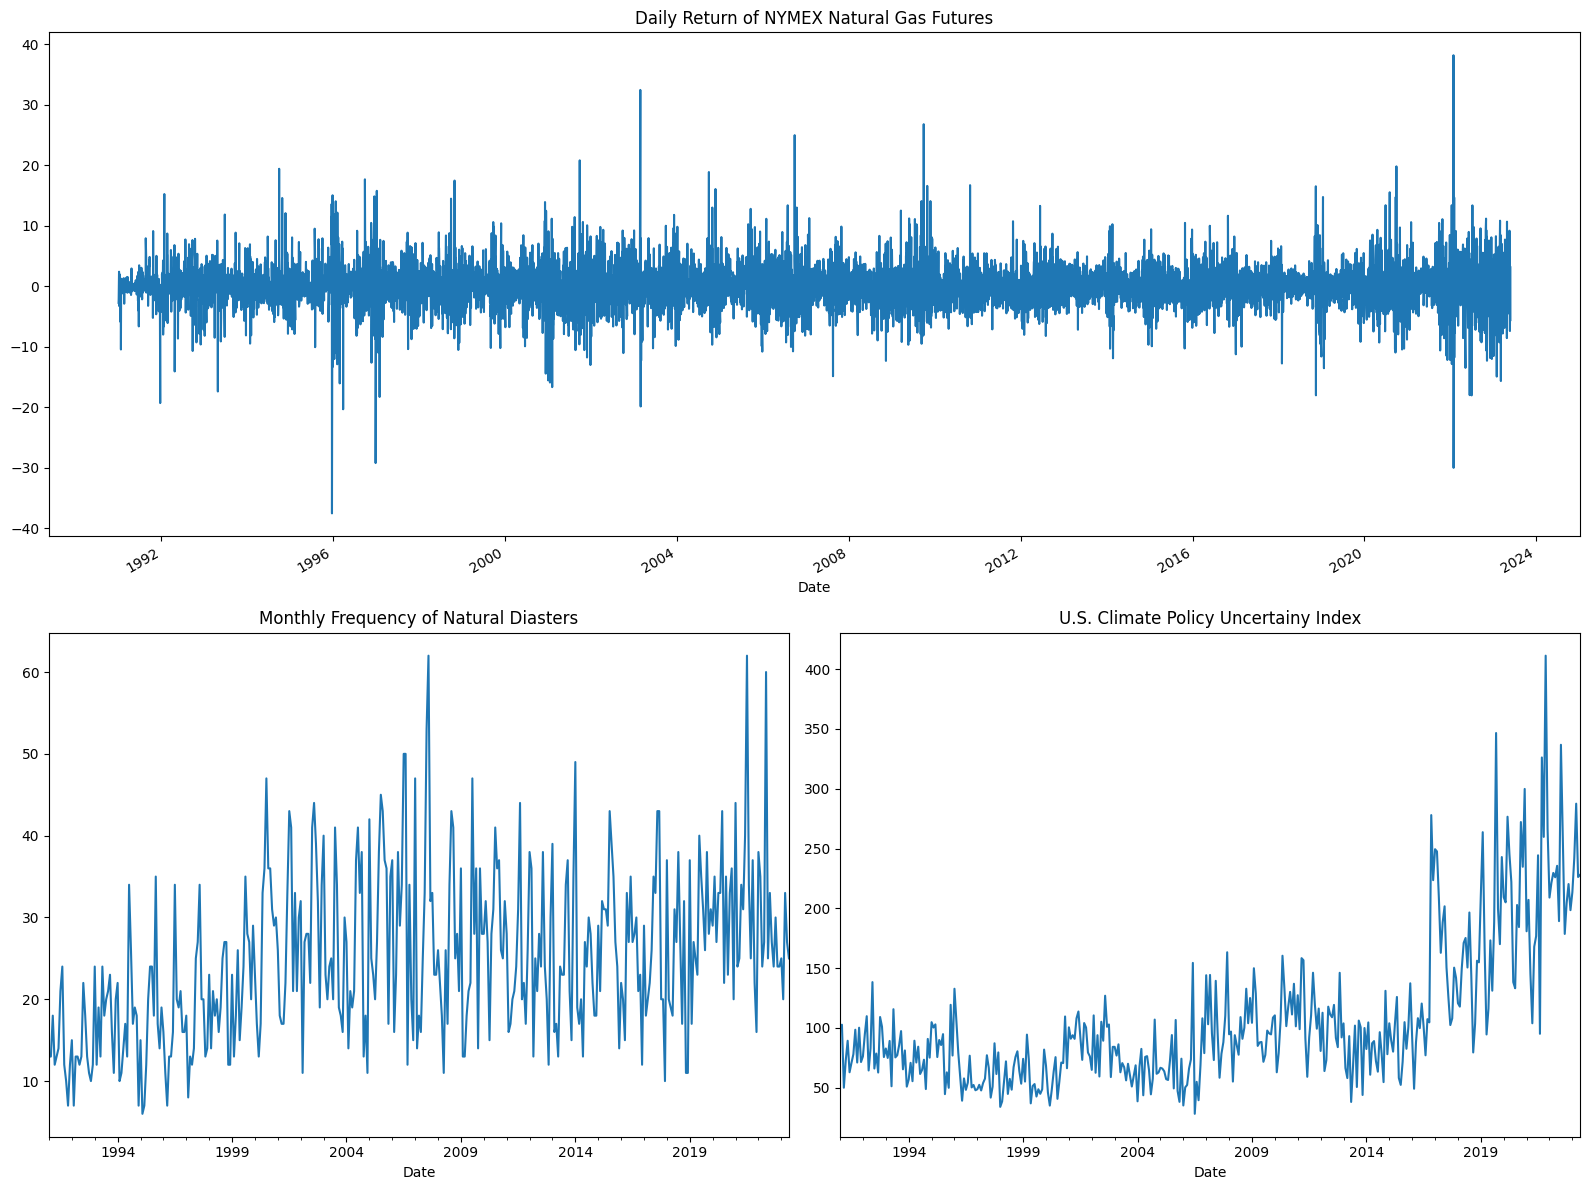

In [ ]:
plot_eda(data)

In [5]:
get_descriptive_stats(data)

,Obs,mean,std,min,max,skewness,kurtosis,ADF,p-val
Data,,,,,,,,,
Natural gas futures return (daily),8070,0.002161,3.616883,-37.574864,38.172676,0.083257,8.048973,-18.021501,2.694326e-30
CPU Index,389,105.695942,59.843765,28.161927,411.288806,1.739263,3.389606,-0.135402,9.457962e-01
d. ln(CPU Index),388,0.002092,0.366836,-1.701375,1.232682,-0.213719,0.834065,-8.054892,1.702952e-12
Natural disasters frequency,389,24.910026,9.990465,6.000000,62.000000,0.654542,0.390277,-2.560320,1.014787e-01
d. ln(Natural disasters frequency),388,0.001685,0.442629,-1.427116,1.339774,-0.035137,0.314798,-8.473852,1.453185e-13


In [6]:
run_kpss_test(data)

,KPSS Statistic,p-value
Data,,
Natural gas futures return (daily),0.058156,0.10
CPU Index,2.106133,0.01
d. CPU Index,0.231059,0.10
d. ln(CPU Index),0.155970,0.10
Natural disasters frequency,2.065823,0.01
d. Natural disasters frequency,0.061992,0.10
d. ln(Natural disasters frequency),0.062230,0.10


# GARCH-MIDAS

Key points:
- Model uses mean-reverting unit daily GARCH process to fit the short-lived component (fast) of the volatility; MIDAS polynomial to depict the secular component driven by some lower frequency variables (slow)


$$r_{i,t} = \mu + \sqrt{\tau_ig_{i,t}}\epsilon_{i,t}, \forall i = 1, 2, ..., N_t$$

whereby
- $r_{i,t}$: price return (log or compound return?)
- $\mu$: mean daily return conditional on information set $\Psi_{i-1}$ 
- $N_t$: number of days in month t
- $g_{i,t}$: short-term component of the conditional probability
- $\tau_t$: secular component


Garch(1,1) process:
$$g_{i,t} = (1 - \alpha - \beta) + \alpha \frac{(r_{i-1,t}-\mu)^2}{\tau_t} + \beta g_{i-1,t}$$


MIDAS regression (which one? hmmm....):
$$\tau_t = m^2 + \underbrace{\theta_R^2 \sum_{k=1}^{K_r} \phi_k(\omega_1, \omega_2) RV_{t-k}}_{\text{Realized vol component}} + \underbrace{\theta_c \sum_{k=1}^{K_c}\phi_k(\omega_{1,c}, \omega_{2,c})X_{t-k}}_{\text{CPU Index or Climate related disaster}} $$

$$log(\tau_t) = m + \underbrace{\theta_R \sum_{k=1}^{K_r} \phi_k(\omega_1, \omega_2) RV_{t-k}}_{\text{Realized vol component}} + \underbrace{\theta_c \sum_{k=1}^{K_c}\phi_k(\omega_{1,c}, \omega_{2,c})X_{t-k}}_{\text{CPU Index or Climate related disaster}} $$

where:
- $RV_t$: realized volatility of daily returns in month $t$
- $K_r$: number of periods over which the realized volatility is smoothed
- $\theta$: measures the contribution of RV to the secular component


Original Study:
- In-sample estimation: January 1, 1991 - December 31, 2021
- Out-sample test: January 1, 2022 - July 29, 2022
- Forecasts in this study were conducted with a rolling-window approach—i.e., using data from January 1, 1991, to December 31,
2021, to project the price volatility on January 1, 2022; using data from January 2, 1991, to January 1, 2022, to project the volatility
on January 2, 2022; and so on.

Further reference:
https://github.com/blake-marsh/GARCH_replication


---
## One-factor GARCH-MIDAS 

### Model 1: Realized Variance, lag = 36

In [7]:
# Get required split for lag = 36
X_36train, X_36test, train36_returns, test36_returns, nbr_test_days36 =\
    is_os_split(data, '2022-12-01', 36, diff = 'first_order')

In [8]:
## initial values - mu, alpha, beta, theta, omega, m
x0 = np.array([0.05, 0.09, 0.90, 1.1, 1, -2])

# method='L-BFGS-B', \
results = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',\
                  args = (train36_returns, X_36train[0], 36)) ## Limited Memory BFGS

results

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18650.603745400495
        x: [ 5.310e-02  8.650e-02  9.001e-01  7.632e-02 -8.457e-02
            -2.009e+00]
      nit: 69
      jac: [-2.183e-03 -8.440e-02 -7.385e-02  1.855e-02  3.638e-03
            -3.114e-01]
     nfev: 868
     njev: 124
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>

In [9]:
_, _, _, tau, _, ht, T =  GARCH_MIDAS(results['x'], train36_returns, X_36train[0], 36, full_output=True)
summary_stats(GARCH_MIDAS, 
              T, 
              results['x'], 
              (train36_returns, X_36train[0], 36), 
              ['mu', 'alpha', 'beta', 'theta', 'omega', 'm'])

,mu,alpha,beta,theta,omega,m
values,0.053098,8.650093e-02,0.900106,0.076325,-0.084575,-2.008710
SE,0.033214,5.945133e-03,0.006445,0.017668,0.118443,2.397602
p-val,0.054968,1.185556e-47,0.000000,0.000008,0.237608,0.201084


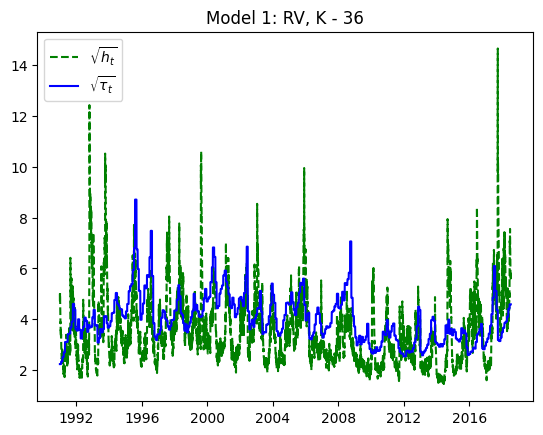

In [10]:
# Generate an array of time intervals
start_date = pd.to_datetime("1991-01-01")

#Generate an array of dates with business day frequency for the US
date_array = pd.date_range(start=start_date, periods=T, freq='B')

plot_results(date_array, ht, tau, title = 'Model 1: RV, K - 36')

---
## Two-factors GARCH-MIDAS

Model 2: RV + CPU, lag = 36

In [11]:
## initial values - mu, alpha, beta, theta1, theta2, omega1, omega2, m
x0 = np.array([0.05, 0.09, 0.90, 0.1, 0.1, 1, 1, -2])

# method='L-BFGS-B', \
results2 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',\
                  args = (train36_returns, X_36train[:2], 36, get_twofactor_tau)) ## Limited Memory BFGS

results2

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18650.628469210154
        x: [ 5.295e-02  8.661e-02  9.001e-01  7.640e-02  1.336e-01
            -8.296e-02  1.027e+00 -1.974e+00]
      nit: 38
      jac: [-1.208e-01 -6.740e+00 -5.763e+00  1.794e+00  1.115e+00
             8.295e-02 -1.058e+00 -3.100e-01]
     nfev: 450
     njev: 50
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>

In [12]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results2['x'], train36_returns, X_36train[:2], 36, get_tau=get_twofactor_tau, full_output=True)


summary_stats(GARCH_MIDAS, 
              T, 
              results2['x'], 
              (train36_returns, X_36train[:2], 36, get_twofactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'omega1', 'omega2','m'])


,mu,alpha,beta,theta1,theta2,omega1,omega2,m
values,0.052951,8.660853e-02,0.900060,0.076400,0.133571,-0.082959,1.027374e+00,-1.974087
SE,0.033032,5.993153e-03,0.006466,0.018435,0.204614,0.124774,1.309541e-01,2.499831
p-val,0.054486,4.808247e-47,0.000000,0.000017,0.256953,0.253077,2.440936e-15,0.214867


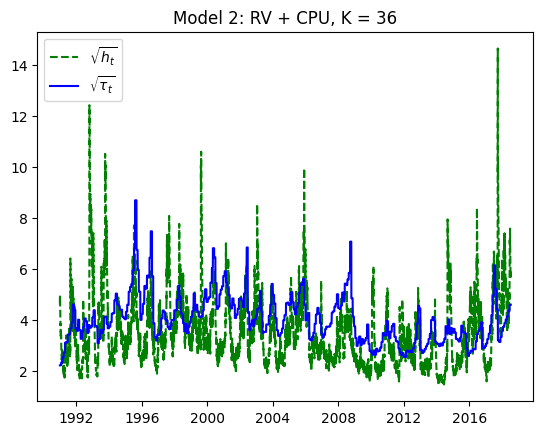

In [13]:
# Plot 
plot_results(date_array, ht, tau, title = 'Model 2: RV + CPU, K = 36')

Model 3: RV + EMDAT, K = 36

In [14]:
# method='L-BFGS-B', \
results3 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',\
                  args = (train36_returns, X_36train[::2], 36, get_twofactor_tau)) ## Limited Memory BFGS

results3

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18650.330325253566
        x: [ 5.299e-02  8.629e-02  9.002e-01  7.571e-02  1.422e-01
            -8.681e-02  1.030e+00 -1.973e+00]
      nit: 41
      jac: [-1.666e-01  8.371e-01  7.090e-01 -1.779e-01 -1.799e+00
            -1.055e-01 -9.059e-01 -3.136e-01]
     nfev: 603
     njev: 67
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>

In [15]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results3['x'], train36_returns, X_36train[::2], 36, get_tau=get_twofactor_tau, full_output=True)


summary_stats(GARCH_MIDAS, 
              T, 
              results3['x'], 
              (train36_returns, X_36train[::2], 36, get_twofactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'omega1', 'omega2','m'])

,mu,alpha,beta,theta1,theta2,omega1,omega2,m
values,0.052987,8.629317e-02,0.900202,0.075713,0.142248,-0.086810,1.029505,-1.973341
SE,0.032923,5.953938e-03,0.006450,0.017759,0.245362,0.126327,0.247944,2.469631
p-val,0.053782,2.643921e-47,0.000000,0.000010,0.281050,0.245994,0.000017,0.212145


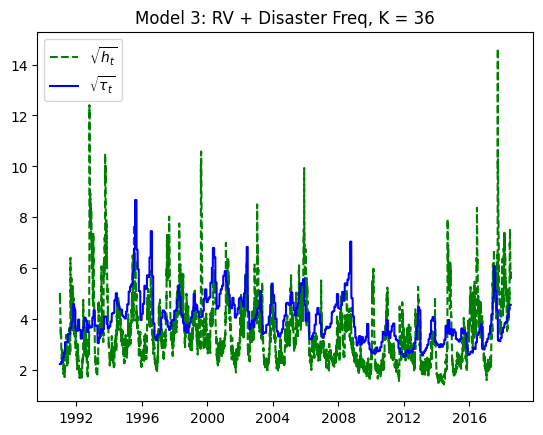

In [16]:
# Plot 
plot_results(date_array, ht, tau, title = 'Model 3: RV + Disaster Freq, K = 36')

Model 4: RV + EMDAT, K = 33

In [17]:
# Get required split for lag = 33
X_33train, X_33test, train33_returns, test33_returns, nbr_test_days33 =\
    is_os_split(data, '2022-12-01', 33, diff = 'first_order')

In [18]:
# method='L-BFGS-B', \
results4 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',\
                  args = (train33_returns, X_33train[::2], 33, get_twofactor_tau)) ## Limited Memory BFGS

results4

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18825.061234105706
        x: [ 4.689e-02  8.974e-02  8.930e-01  2.850e-02  3.871e+00
             2.165e-02  9.484e-01  6.521e+00]
      nit: 128
      jac: [-9.022e-02 -3.434e-01 -5.886e-01 -6.985e-01 -2.183e-03
             3.274e-03  1.892e-02 -2.910e-03]
     nfev: 1413
     njev: 157
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>

In [19]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results4['x'], train33_returns, X_33train[::2], 33, get_tau=get_twofactor_tau, full_output=True)


summary_stats(GARCH_MIDAS, 
              T, 
              results4['x'], 
              (train33_returns, X_33train[::2], 33, get_twofactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'omega1', 'omega2','m'])

,mu,alpha,beta,theta1,theta2,omega1,omega2,m
values,0.046892,8.974030e-02,0.893015,0.028499,3.870913,0.021654,9.483600e-01,6.520695
SE,0.032899,6.092988e-03,0.006961,0.008848,0.951131,0.122777,1.003309e-01,1.925888
p-val,0.077051,9.191982e-49,0.000000,0.000642,0.000024,0.430006,2.138355e-21,0.000357


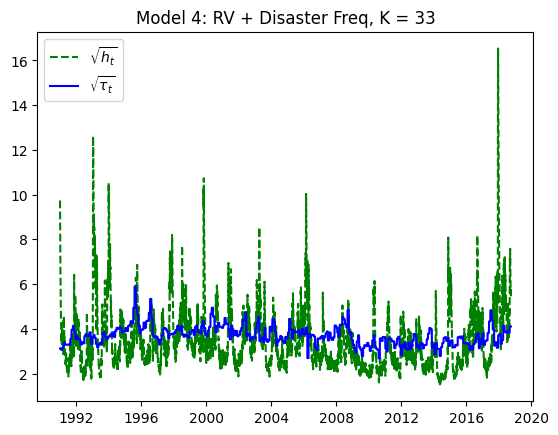

In [20]:
date_array33 = pd.date_range(start=start_date, periods=T, freq='B')

# Plot 
plot_results(date_array33, ht, tau, title = 'Model 4: RV + Disaster Freq, K = 33')

---
## Three-Factors GARCH-MIDAS
Model 5: RV + CPU + EMDAT, K = 36

In [21]:
## initial values - mu, alpha, beta, theta1, theta2, theta3, omega1, omega2, omega3, m
x0 = np.array([0.0005, 0.09, 0.90, 0.1, 0.1, 0.1, 1, 1, 1, -2])

results5 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',
                  args = (train36_returns, X_36train, 
                          36, get_threefactor_tau)) ## Limited Memory BFGS

results5

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18644.62610951697
        x: [ 5.539e-02  8.415e-02  9.016e-01  7.147e-02  1.569e-01
             1.925e+00 -1.145e-01  1.669e+00  2.086e+00 -1.677e+00]
      nit: 81
      jac: [ 5.348e-02 -2.086e+00 -1.481e+00  1.165e+00 -1.120e-01
            -3.449e-01  2.256e-02 -4.839e-02  6.894e-01 -2.667e-01]
     nfev: 1353
     njev: 123
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>

In [22]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results5['x'], train36_returns, X_36train, 36, get_tau=get_threefactor_tau, full_output=True)

summary_stats(GARCH_MIDAS, 
              T, 
              results5['x'], 
              (train36_returns, X_36train, 36, get_threefactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'theta3', 'omega1', 'omega2', 'omega3', 'm'])

,mu,alpha,beta,theta1,theta2,theta3,omega1,omega2,omega3,m
values,0.055386,8.415112e-02,0.901572,0.071466,0.156919,1.925134e+00,-0.114472,1.668883,2.086485e+00,-1.676764
SE,0.033396,5.881645e-03,0.006540,0.015491,0.250054,3.614138e-01,0.125543,1.222263,3.346482e-01,2.238510
p-val,0.048633,3.645554e-46,0.000000,0.000002,0.265162,5.138458e-08,0.180946,0.086082,2.376479e-10,0.226924


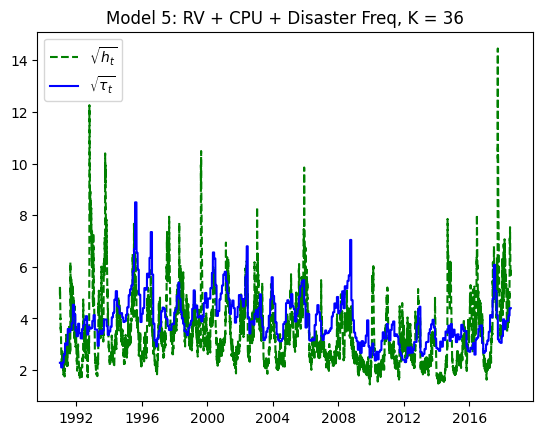

In [23]:
# Plot 
plot_results(date_array, ht, tau, title = 'Model 5: RV + CPU + Disaster Freq, K = 36')

Model 6: RV + CPU + EMDAT, K = 33

In [24]:
## initial values - mu, alpha, beta, theta1, theta2, omega1, omega2, m
x0 = np.array([0.0005, 0.09, 0.90, 0.1, 0.1, 0.1, 1, 1, 1, -2])

results6 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',
                  args = (train33_returns, X_33train, 
                          33, get_threefactor_tau)) ## Limited Memory BFGS

results6

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18823.31386350501
        x: [ 4.739e-02  8.954e-02  8.927e-01  3.047e-02  2.995e-01
             3.960e+00  2.880e-02  2.432e+00  9.410e-01  5.948e+00]
      nit: 198
      jac: [ 2.161e-01 -1.017e+00  4.693e-02  8.975e-01 -8.695e-02
            -1.273e-02  6.003e-02 -4.366e-02  1.080e-01  3.638e-03]
     nfev: 2673
     njev: 243
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>

In [25]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results6['x'], 
                                                  train33_returns, X_33train, 
                                                  33, 
                                                  get_tau=get_threefactor_tau, 
                                                  full_output=True)

summary_stats(GARCH_MIDAS, 
              T, 
              results6['x'], 
              (train33_returns, X_33train, 
              33, 
              get_threefactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'theta3', 'omega1', 'omega2', 'omega3', 'm'])


,mu,alpha,beta,theta1,theta2,theta3,omega1,omega2,omega3,m
values,0.047388,8.954272e-02,0.892734,0.030467,0.299478,3.960107,0.028805,2.431588,9.409970e-01,5.947516
SE,0.033280,6.181532e-03,0.007130,0.009230,0.273362,0.948353,0.170455,1.991801,9.921394e-02,1.988752
p-val,0.077252,2.960087e-47,0.000000,0.000484,0.136657,0.000015,0.432905,0.111099,1.576669e-21,0.001397


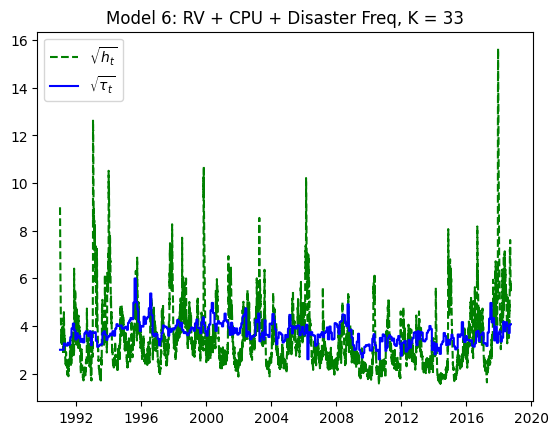

In [26]:
# Plot 
plot_results(date_array33, ht, tau, title = 'Model 6: RV + CPU + Disaster Freq, K = 33')

---
## Out-sample Analysis

$$L_{MSE} = \frac{1}{N_O - \sum_{t=1}^E N_t}\sum_{t = E+1}^{T}\sum_{i = 1}^{N_t}(\sigma_{i,t} - \sqrt{\hat{\tau_t}\hat{g_{i,t}}})^2$$

$$L_{MAE} = \frac{1}{N_O - \sum_{t=1}^E N_t}\sum_{t = E+1}^{T}\sum_{i = 1}^{N_t}|\sigma_{i,t} - \sqrt{\hat{\tau_t}\hat{g_{i,t}}}|$$

In [27]:
df_realized_vol = pd.read_csv('./data/intraday_realized_volatility.csv', 
                              encoding_errors='ignore')

df_realized_vol.set_index('Date', inplace = True)
df_realized_vol.index = pd.to_datetime(df_realized_vol.index)

realized_vol = np.array(df_realized_vol.loc[df_realized_vol.index >= '2022-12-01', 'Volatility'])

In [28]:
LMSE1, LMAE1 = out_sample_test(test36_returns, realized_vol, X_36test[0], 36, results, nbr_test_days36, [10,30,60,90,118])
LMSE2, LMAE2 = out_sample_test(test36_returns, realized_vol, X_36test[:2], 36, results2, nbr_test_days36, [10,30,60,90,118])
LMSE3, LMAE3 = out_sample_test(test36_returns, realized_vol, X_36test[::2], 36, results3, nbr_test_days36, [10,30,60,90,118])
LMSE4, LMAE4 = out_sample_test(test33_returns, realized_vol, X_33test[::2], 33, results4, nbr_test_days33, [10,30,60,90,118])
LMSE5, LMAE5 = out_sample_test(test36_returns, realized_vol, X_36test, 36, results5, nbr_test_days36, [10,30,60,90,118])
LMSE6, LMAE6 = out_sample_test(test33_returns, realized_vol, X_33test, 33, results6, nbr_test_days33, [10,30,60,90,118])

In [29]:
pd.DataFrame({
    'MSE (RV, K = 36)' : LMSE1,
    'MAE (RV, K = 36)' : LMAE1,
    'MSE (RV + CPU, K = 36)' : LMSE2,
    'MAE (RV + CPU, K = 36)' : LMAE2,
    'MSE (RV + EMDAT, K = 36)' : LMSE3,
    'MAE (RV + EMDAT, K = 36)' : LMAE3,
    'MSE (RV + EMDAT, K = 33)' : LMSE4,
    'MAE (RV + EMDAT, K = 33)' : LMAE4,
    'MSE (RV + CPU + EMDAT, K = 36)' : LMSE5,
    'MAE (RV + CPU + EMDAT, K = 36)' : LMAE5,
    'MSE (RV + CPU + EMDAT, K = 33)' : LMSE6,
    'MAE (RV + CPU + EMDAT, K = 33)' : LMAE6,
}, index = ['10 days forecast','30 days forecast','60 days forecast','90 days forecast', '118 days forecast']).T

,10 days forecast,30 days forecast,60 days forecast,90 days forecast,118 days forecast
"MSE (RV, K = 36)",0.000046,0.000094,0.000129,0.000173,0.000159
"MAE (RV, K = 36)",0.005703,0.007915,0.009201,0.011031,0.010577
"MSE (RV + CPU, K = 36)",0.000048,0.000095,0.000130,0.000175,0.000160
"MAE (RV + CPU, K = 36)",0.005912,0.007978,0.009267,0.011095,0.010620
"MSE (RV + EMDAT, K = 36)",0.000045,0.000094,0.000128,0.000173,0.000158
"MAE (RV + EMDAT, K = 36)",0.005670,0.007880,0.009177,0.011004,0.010553
"MSE (RV + EMDAT, K = 33)",0.000037,0.000092,0.000095,0.000113,0.000114
"MAE (RV + EMDAT, K = 33)",0.004858,0.007652,0.007767,0.008633,0.008679
"MSE (RV + CPU + EMDAT, K = 36)",0.000037,0.000084,0.000124,0.000168,0.000155
"MAE (RV + CPU + EMDAT, K = 36)",0.004939,0.007331,0.008914,0.010805,0.010396


In [30]:
models_to_test =\
    [(test36_returns, X_36test[0],36,results, nbr_test_days36),
        (test36_returns, X_36test[:2],36,results2, nbr_test_days36),
        (test36_returns, X_36test[::2],36,results3, nbr_test_days36),
        (test33_returns, X_33test[::2],33,results4, nbr_test_days33),
        (test36_returns, X_36test,36,results5, nbr_test_days36),
        (test33_returns, X_33test,33,results6, nbr_test_days33)]

MCS_MSE_10, MCS_MAE_10 =\
    mcs_test(realized_vol, 
             models_to_test,
             10)

MCS_MSE_30, MCS_MAE_30 =\
    mcs_test(realized_vol, 
             models_to_test,
             30)

MCS_MSE_60, MCS_MAE_60 =\
    mcs_test(realized_vol, 
             models_to_test,
             60)

MCS_MSE_90, MCS_MAE_90 =\
    mcs_test(realized_vol, 
             models_to_test,
             90)

MCS_MSE_118, MCS_MAE_118 =\
    mcs_test(realized_vol, 
             models_to_test,
             118)

Computing MCS: 100%|█████████████████████████| 5/5 [00:00<00:00, 2238.87model/s]


In [31]:
MCS10 = pd.merge(MCS_MSE_10.sort_index()[['pvalues']],MCS_MAE_10.sort_index()[['pvalues']], on = 'models',how='inner')
MCS30 = pd.merge(MCS_MSE_30.sort_index()[['pvalues']],MCS_MAE_30.sort_index()[['pvalues']], on = 'models',how='inner')
MCS60 = pd.merge(MCS_MSE_60.sort_index()[['pvalues']],MCS_MAE_60.sort_index()[['pvalues']], on = 'models',how='inner')
MCS90 = pd.merge(MCS_MSE_90.sort_index()[['pvalues']],MCS_MAE_90.sort_index()[['pvalues']], on = 'models',how='inner')
MCS118 = pd.merge(MCS_MSE_118.sort_index()[['pvalues']],MCS_MAE_118.sort_index()[['pvalues']], on = 'models',how='inner')

In [32]:
merged_mcs = pd.concat([MCS10, MCS30,MCS60,MCS90,MCS118], keys=['10 days', '30 days', '60 days', '90 days', '120 days'])
merged_mcs = merged_mcs.rename(columns={'pvalues_x' : 'MCS_mae', 'pvalues_y' : 'MCS_mse'})
new_index_values = ['RV (K=36)', 'RV+CPU (K=36)', 'RV+EMDAT (K=36)', 'RV+EMDAT (K=33)', 'RV+CPU+EMDAT (K=36)','RV+CPU+EMDAT (K=33)']  # New values for the second level index
merged_mcs.index = merged_mcs.index.set_levels(new_index_values, level=1)
merged_mcs

MCS_mae  MCS_mse
         models                               
10 days  RV (K=36)                0.0      0.0
         RV+CPU (K=36)            0.0      0.0
         RV+EMDAT (K=36)          0.0      0.0
         RV+EMDAT (K=33)          0.0      1.0
         RV+CPU+EMDAT (K=36)      1.0      0.0
         RV+CPU+EMDAT (K=33)      0.0      0.0
30 days  RV (K=36)                0.0      0.0
         RV+CPU (K=36)            0.0      0.0
         RV+EMDAT (K=36)          0.0      0.0
         RV+EMDAT (K=33)          0.0      0.0
         RV+CPU+EMDAT (K=36)      1.0      1.0
         RV+CPU+EMDAT (K=33)      0.0      0.0
60 days  RV (K=36)                0.0      0.0
         RV+CPU (K=36)            0.0      0.0
         RV+EMDAT (K=36)          0.0      0.0
         RV+EMDAT (K=33)          1.0      1.0
         RV+CPU+EMDAT (K=36)      0.0      0.0
         RV+CPU+EMDAT (K=33)      0.0      0.0
90 days  RV (K=36)                0.0      0.0
         RV+CPU (K=36)            0.0      0.0
         RV+EMDAT (K=36)          0.0      0.0
         RV+EMDAT (K=33)          1.0      1.0
         RV+CPU+EMDAT (K=36)      0.0      0.0
         RV+CPU+EMDAT (K=33)      0.0      0.0
120 days RV (K=36)                0.0      0.0
         RV+CPU (K=36)            0.0      0.0
         RV+EMDAT (K=36)          0.0      0.0
         RV+EMDAT (K=33)          1.0      1.0
         RV+CPU+EMDAT (K=36)      0.0      0.0
         RV+CPU+EMDAT (K=33)      0.0      0.0

### MCS Analysis Starts

In [33]:
def run_mcs(lookahead,loss_fun):
    
    if (loss_fun=='mse'):
        result_idx=0
    elif (loss_fun=='mae'):
        result_idx=1
    else:
        print("Wrong Loss fun type. Please input either 'mse' or 'mae'")
    
    all_results = {}
    models_to_test =\
        [(test36_returns, X_36test[0],36,results, nbr_test_days36),
        (test36_returns, X_36test[:2],36,results2, nbr_test_days36),
        (test36_returns, X_36test[::2],36,results3, nbr_test_days36),
        (test33_returns, X_33test[::2],33,results4, nbr_test_days33),
        (test36_returns, X_36test,36,results5, nbr_test_days36),
        (test33_returns, X_33test,33,results6, nbr_test_days33)]
    
    index_values = ['RV (K=36)', 'RV+CPU (K=36)', 'RV+EMDAT (K=36)', 'RV+EMDAT (K=33)', 'RV+CPU+EMDAT (K=36)','RV+CPU+EMDAT (K=33)']  # New values for the second level index

    for i in range(1,len(models_to_test)):
        result = mcs_test(realized_vol,models_to_test,lookahead)[result_idx].sort_index()[['pvalues']]
        result.index = index_values
        all_results[f'Test_{i}'] = result
        best_models = result.index[result['pvalues'] == 1].tolist()
        best_idx = index_values.index(best_models[0])
        index_values.pop(best_idx)
        models_to_test.pop(best_idx)
    
    merged_df = all_results['Test_1']
    merged_df = merged_df.add_suffix(f'_Test_1')

    for i in range(2,6):
        df = all_results[f'Test_{i}']
        df = df.add_suffix(f'_Test_{i}')
        merged_df = pd.merge(merged_df, df, left_index=True, right_index=True, how='left')
    
        
    return merged_df

In [34]:
def run_msc_allalphas(lookahead,loss_fun):
    df_dict = {}
    df_names=[]
    alphas = [0.1]
    for i in alphas:
        df_dict[f'alpha_{i}']=run_mcs(lookahead,loss_fun)
        df_names.append(f'alpha_{i}')
    
    return pd.concat(df_dict)

In [35]:
def run_msc_all(loss_fun):
    lookaheads = [10,30,60,90,118]
    df_dict = {}
    df_names= []
    for i in lookaheads:
        df_dict[f'{i} days'] = run_msc_allalphas(i,loss_fun)
        df_names.append(f'{i} days')
    return pd.concat(df_dict)

In [36]:
pd.set_option('display.max_rows', None)
msc_mse=run_msc_all('mse')
msc_mae=run_msc_all('mae')


Bootstrapping: 100%|█████████████████████| 1000/1000 [00:00<00:00, 69266.66it/s]


Computing MCS: 100%|█████████████████████████| 1/1 [00:00<00:00, 1426.63model/s]


In [37]:
msc_mse

pvalues_Test_1  pvalues_Test_2  \
10 days  alpha_0.1 RV (K=36)                       0.0             0.0   
                   RV+CPU (K=36)                   0.0             0.0   
                   RV+EMDAT (K=36)                 0.0             0.0   
                   RV+EMDAT (K=33)                 0.0             1.0   
                   RV+CPU+EMDAT (K=36)             1.0             NaN   
                   RV+CPU+EMDAT (K=33)             0.0             0.0   
30 days  alpha_0.1 RV (K=36)                       0.0             0.0   
                   RV+CPU (K=36)                   0.0             0.0   
                   RV+EMDAT (K=36)                 0.0             0.0   
                   RV+EMDAT (K=33)                 0.0             1.0   
                   RV+CPU+EMDAT (K=36)             1.0             NaN   
                   RV+CPU+EMDAT (K=33)             0.0             0.0   
60 days  alpha_0.1 RV (K=36)                       0.0             0.0   
                   RV+CPU (K=36)                   0.0             0.0   
                   RV+EMDAT (K=36)                 0.0             0.0   
                   RV+EMDAT (K=33)                 1.0             NaN   
                   RV+CPU+EMDAT (K=36)             0.0             0.0   
                   RV+CPU+EMDAT (K=33)             0.0             1.0   
90 days  alpha_0.1 RV (K=36)                       0.0             0.0   
                   RV+CPU (K=36)                   0.0             0.0   
                   RV+EMDAT (K=36)                 0.0             0.0   
                   RV+EMDAT (K=33)                 1.0             NaN   
                   RV+CPU+EMDAT (K=36)             0.0             0.0   
                   RV+CPU+EMDAT (K=33)             0.0             1.0   
118 days alpha_0.1 RV (K=36)                       0.0             0.0   
                   RV+CPU (K=36)                   0.0             0.0   
                   RV+EMDAT (K=36)                 0.0             0.0   
                   RV+EMDAT (K=33)                 1.0             NaN   
                   RV+CPU+EMDAT (K=36)             0.0             0.0   
                   RV+CPU+EMDAT (K=33)             0.0             1.0   

                                        pvalues_Test_3  pvalues_Test_4  \
10 days  alpha_0.1 RV (K=36)                       0.0             0.0   
                   RV+CPU (K=36)                   0.0             0.0   
                   RV+EMDAT (K=36)                 0.0             1.0   
                   RV+EMDAT (K=33)                 NaN             NaN   
                   RV+CPU+EMDAT (K=36)             NaN             NaN   
                   RV+CPU+EMDAT (K=33)             1.0             NaN   
30 days  alpha_0.1 RV (K=36)                       0.0             0.0   
                   RV+CPU (K=36)                   0.0             0.0   
                   RV+EMDAT (K=36)                 0.0             1.0   
                   RV+EMDAT (K=33)                 NaN             NaN   
                   RV+CPU+EMDAT (K=36)             NaN             NaN   
                   RV+CPU+EMDAT (K=33)             1.0             NaN   
60 days  alpha_0.1 RV (K=36)                       0.0             0.0   
                   RV+CPU (K=36)                   0.0             0.0   
                   RV+EMDAT (K=36)                 0.0             1.0   
                   RV+EMDAT (K=33)                 NaN             NaN   
                   RV+CPU+EMDAT (K=36)             1.0             NaN   
                   RV+CPU+EMDAT (K=33)             NaN             NaN   
90 days  alpha_0.1 RV (K=36)                       0.0             0.0   
                   RV+CPU (K=36)                   0.0             0.0   
                   RV+EMDAT (K=36)                 0.0             1.0   
                   RV+EMDAT (K=33)                 NaN             NaN   
                   RV+CPU+EMDAT (K=36)     

In [38]:
msc_mae

pvalues_Test_1  pvalues_Test_2  \
10 days  alpha_0.1 RV (K=36)                       0.0             0.0   
                   RV+CPU (K=36)                   0.0             0.0   
                   RV+EMDAT (K=36)                 0.0             0.0   
                   RV+EMDAT (K=33)                 1.0             NaN   
                   RV+CPU+EMDAT (K=36)             0.0             1.0   
                   RV+CPU+EMDAT (K=33)             0.0             0.0   
30 days  alpha_0.1 RV (K=36)                       0.0             0.0   
                   RV+CPU (K=36)                   0.0             0.0   
                   RV+EMDAT (K=36)                 0.0             0.0   
                   RV+EMDAT (K=33)                 0.0             1.0   
                   RV+CPU+EMDAT (K=36)             1.0             NaN   
                   RV+CPU+EMDAT (K=33)             0.0             0.0   
60 days  alpha_0.1 RV (K=36)                       0.0             0.0   
                   RV+CPU (K=36)                   0.0             0.0   
                   RV+EMDAT (K=36)                 0.0             0.0   
                   RV+EMDAT (K=33)                 1.0             NaN   
                   RV+CPU+EMDAT (K=36)             0.0             0.0   
                   RV+CPU+EMDAT (K=33)             0.0             1.0   
90 days  alpha_0.1 RV (K=36)                       0.0             0.0   
                   RV+CPU (K=36)                   0.0             0.0   
                   RV+EMDAT (K=36)                 0.0             0.0   
                   RV+EMDAT (K=33)                 1.0             NaN   
                   RV+CPU+EMDAT (K=36)             0.0             0.0   
                   RV+CPU+EMDAT (K=33)             0.0             1.0   
118 days alpha_0.1 RV (K=36)                       0.0             0.0   
                   RV+CPU (K=36)                   0.0             0.0   
                   RV+EMDAT (K=36)                 0.0             0.0   
                   RV+EMDAT (K=33)                 1.0             NaN   
                   RV+CPU+EMDAT (K=36)             0.0             0.0   
                   RV+CPU+EMDAT (K=33)             0.0             1.0   

                                        pvalues_Test_3  pvalues_Test_4  \
10 days  alpha_0.1 RV (K=36)                       0.0             0.0   
                   RV+CPU (K=36)                   0.0             0.0   
                   RV+EMDAT (K=36)                 0.0             1.0   
                   RV+EMDAT (K=33)                 NaN             NaN   
                   RV+CPU+EMDAT (K=36)             NaN             NaN   
                   RV+CPU+EMDAT (K=33)             1.0             NaN   
30 days  alpha_0.1 RV (K=36)                       0.0             0.0   
                   RV+CPU (K=36)                   0.0             0.0   
                   RV+EMDAT (K=36)                 0.0             1.0   
                   RV+EMDAT (K=33)                 NaN             NaN   
                   RV+CPU+EMDAT (K=36)             NaN             NaN   
                   RV+CPU+EMDAT (K=33)             1.0             NaN   
60 days  alpha_0.1 RV (K=36)                       0.0             0.0   
                   RV+CPU (K=36)                   0.0             0.0   
                   RV+EMDAT (K=36)                 0.0             1.0   
                   RV+EMDAT (K=33)                 NaN             NaN   
                   RV+CPU+EMDAT (K=36)             1.0             NaN   
                   RV+CPU+EMDAT (K=33)             NaN             NaN   
90 days  alpha_0.1 RV (K=36)                       0.0             0.0   
                   RV+CPU (K=36)                   0.0             0.0   
                   RV+EMDAT (K=36)                 0.0             1.0   
                   RV+EMDAT (K=33)                 NaN             NaN   
                   RV+CPU+EMDAT (K=36)     

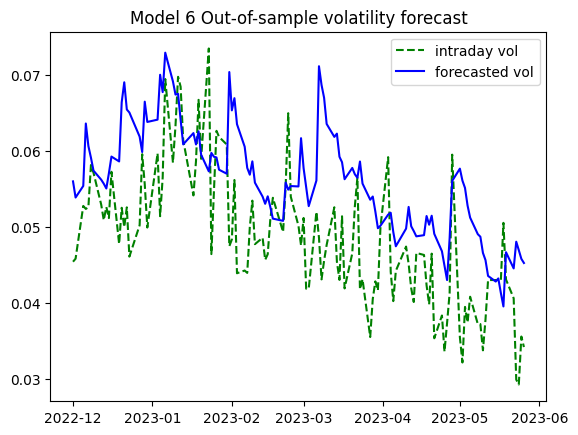

In [39]:
loglik, logliks, e, tau, gt, ht, T =\
    GARCH_MIDAS(results6['x'], 
                test33_returns, X_33test, 
                33, 
                get_tau=get_threefactor_tau, 
                full_output=True)

rlzd_daily_vol = realized_vol/np.sqrt(252)
forecast_vol = np.sqrt(ht[-nbr_test_days33:])/100

x = np.array(data.index[data.index >= '2022-12-01'])

plt.title("Model 6 Out-of-sample volatility forecast")

plt.plot(x, rlzd_daily_vol, 'g--', label = 'intraday vol')
plt.plot(x, forecast_vol,'b-', label = 'forecasted vol')
plt.legend()
plt.show()